# 03. From Kernel to Convolutional Neural Network

<div style="margin:.3rem 0 1rem;font-size:.9em;color:#555;display:flex;align-items:center;gap:.35rem;font-family:monospace">
  <time datetime="2025-02-15">15 Feb 2025</time> /
  <time datetime="2025-02-06">6 Feb 2026</time>
</div>

<a href="https://colab.research.google.com/github/shahaliyev/csci4701/blob/main/docs/notebooks/03_cnn_torch.ipynb"
   target="_blank" rel="noopener">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open in Colab"
  />
</a>

In previous notebooks, we learned how to build a [neural network](../02_neural_network). We will  discuss many [optimization and regularization](../04_regul_optim) techniques (e.g. parameter initialization, momentum, weight decay, dropout, [batch normalization](../06_batchnorm_resnet), etc.) to improve the efficiency of our training. But before that, we need to understand [convolutional neural networks (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) which are used in image processing and gain a basic understanding of the PyTorch framework. And even before that, we need to know what an image is.

 ## Images with PyTorch

 A grayscale image is simply a 2D array holding pixel values, often ranging between $0$ and $1$ (normalized) or $0$ and $255$ ([8 bits](https://ada-site.github.io/SITE-1101/Lecture_Notes/02_binary)), representing the range of intensities between two colors: black and white. A colored image often is represented by the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model), where we have 3 sets (channels) of 2D arrays for red, green, and blue. Combinations of three values represent additional colors to black and white (e.g. $[255, 0, 0]$ is red).

 We will create a toy image to get a feeling of how images are stored in the memory. We will also delibarately use `torch` library to familiarize ourselves with PyTorch functions. In PyTorch, images are stored in `(C, H, W)` format, corresponding to _channel_, _height_, and _width_. Note that batch size can also be included `(B, C, H, W)`. _Batch_ is simply a subset of a dataset. We  should process our dataset in batches in order to not load all the images at once to the [RAM memory](https://ada-site.github.io/SITE-1101/Lecture_Notes/03_hardware/), which is usually limited to several Gigabytes.
<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
    If you are using Google Colab, see the top right corner of the notebook for RAM information.
  </p>
</div>

[Tensor](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) is the main data abstraction in PyTorch, similar to `numpy` arrays. Tensors are optimized for GPU and can calculate gradients with its [autograd](../01_backprop) engine. Inspired by [micrograd](https://github.com/karpathy/micrograd) the `Value` class which have been developing over the course previous notebooks was merely a simplified (scalar) version of `torch.Tensor`.

In [1]:
import torch

<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
    PyTorch libraries come pre-installed in Google Colab. If you are using local development, you should use official <a href='https://pytorch.org/get-started/locally/'>PyTorch installer</a>.
  </p>
</div>

The code below is for plotting purposes. Even though we call it a grayscale image, [matplotlib](https://matplotlib.org/) is actually displaying the matrix values using a color map (`cmap`), meaning the intensities could be mapped not only to black and white but to any range of two colors depending on the chosen color map.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# this is for plotting, no need to understand
def plot(img_tensors, titles=None, cmap='gray'):
  if not isinstance(img_tensors, list):
    img_tensors = [img_tensors]
  if not isinstance(titles, list):
    titles = [titles] * len(img_tensors)
  fig, axes = plt.subplots(1, len(img_tensors), figsize=(len(img_tensors) * 4, 4))
  if len(img_tensors) == 1:
    axes = [axes]

  for ax, img_tensor, title in zip(axes, img_tensors, titles):
    img_tensor = img_tensor.cpu()
    img = img_tensor.permute(1, 2, 0).numpy()
    ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    ax.axis("off")
  plt.show()

We will now generate matrices of dimension $height \times width$. In case of grayscale image, we need only a single matrix. For true color images, we need three of such matrices, one for each color channel (RGB). To generate random intensities of the required shape, we will call `torch.rand`.

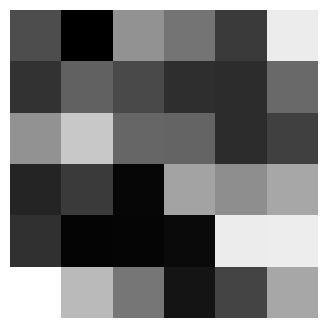

In [3]:
color = ['gray','rgb'][0] # change 0 to 1 for rgb

H = W = 6
C = 3 if color == 'rgb' else 1

img = torch.rand((C, H, W))
plot(img)

In [4]:
img

tensor([[[0.3080, 0.0262, 0.5574, 0.4494, 0.2400, 0.8864],
         [0.2101, 0.3828, 0.2922, 0.1948, 0.1911, 0.4098],
         [0.5587, 0.7565, 0.3989, 0.3920, 0.1915, 0.2599],
         [0.1623, 0.2396, 0.0493, 0.6253, 0.5448, 0.6362],
         [0.2075, 0.0440, 0.0468, 0.0656, 0.8846, 0.8893],
         [0.9567, 0.7053, 0.4556, 0.0996, 0.2754, 0.6344]]])

Technically, if we have image labels, and enough images in the dataset, we can already train a neural network to make predictions. For that, we can turn our 2D (grayscale) or 3D (RGB) tensors into $1$-dimensional vectors and feed in to our model. For example, and image with input dimensions $3 \times 32 \times 32$, which corresponds to a $32 \times 32$ pixel RGB image, can be reshaped into a single dimensional vector of size `3*32*32` which will be the input dimension of our network.


<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
     What will be the shape of an $6 \times 6$ grayscale image after reshaping?
  </p>
</div>

At this point, we will not delve into details. It is worth, however, to understand that `img.reshape(-1)`, `img.reshape(1,-1)`, `img.reshape(1,1,-1)` will all return a flattened image matrix that will look similar while having different dimensions (shapes).

<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
     See this <a href='https://cs231n.github.io/python-numpy-tutorial/'>numpy tutorial</a> to gain experinece with matrix manipulations and other useful operations (e.g. <a href='https://numpy.org/devdocs/user/basics.broadcasting.html'>broadcasting</a>).
  </p>
</div>

In [5]:
img.reshape(1, 1, -1)

tensor([[[0.3080, 0.0262, 0.5574, 0.4494, 0.2400, 0.8864, 0.2101, 0.3828,
          0.2922, 0.1948, 0.1911, 0.4098, 0.5587, 0.7565, 0.3989, 0.3920,
          0.1915, 0.2599, 0.1623, 0.2396, 0.0493, 0.6253, 0.5448, 0.6362,
          0.2075, 0.0440, 0.0468, 0.0656, 0.8846, 0.8893, 0.9567, 0.7053,
          0.4556, 0.0996, 0.2754, 0.6344]]])

## MNIST Dataset

We will download and train our model on the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset mentioned in our [introduction](../../introduction/01_deep_learning), which has 70,000 grayscale $28 \times 28$ images of hand-written digits with their labels. Our main goal, for now, is to familiarize ourselves with PyTorch.

<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
     See the official <a href='https://pytorch.org/tutorials/beginner/basics/data_tutorial.html'>Datasets and DataLoaders tutorial</a> for further guidance.
  </p>
</div>

The code below will download and load the MNIST dataset by enforcing tensor-valued representations of images.

In [ ]:
from torchvision import datasets, transforms

train_data = datasets.MNIST(root='./data', train=True,  transform=transforms.ToTensor(), download=True)
test_data  = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
      What other <a href='https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html'>transforms</a> can we apply to our dataset and why?What is the use of <code>num_workers</code> and <code>batch_size</code> demonstrated below? Why do we <em>shuffle</em> the <code>train</code> data but not the <code>test</code> data?
  </p>
</div>

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, num_workers=2, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=64, num_workers=2, shuffle=False)

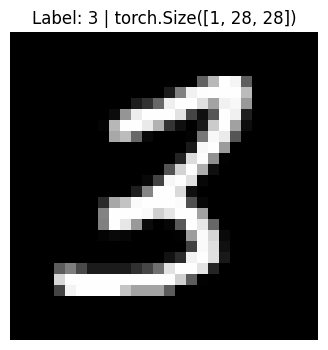

In [9]:
X_train, y_train = next(iter(train_loader)) # gets the images of the batch
plot(X_train[0], f'Label: {y_train[0].item()} | {X_train[0].shape}')

In PyTorch, there are more than one way to manipulate a multi-dimensional tensor into a different dimension. It is worth understanding the [internals of PyTorch](http://blog.ezyang.com/2019/05/pytorch-internals/) and the workings of the equivalent methods below, especially the difference of memory management between `reshape` and `view` functions. We can see the number of elements (pixels) with `numel` function as described below.

In [10]:
# X_train[0].view(-1).shape[0]
# X_train[0].reshape(-1).shape[0]
# X_train[0].flatten().shape[0]
X_train[0].numel() # 1x28x28

784

## Training Model on MNIST

We will now build a simple neural network and train our model on MNIST. This time, not from the scratch :). When we build our custom network, we need to inherit from `torch.nn.Module` which will handle many useful operations (e.g. automatic [differentiation](../../mathematics/01_calculus)). It will also enforce us to define our forward pass function. Our activation function will be non-linear [rectified linear unit](https://en.wikipedia.org/wiki/Rectified_linear_unit).

Fully connected (FC) layer (also known as Dense layer) is simply a network layer where all the neurons are connected to the previous layer neurons (recall [multilayer perceptrons (MLP)](../02_neural_network)). When applying forward pass, we should reshape our input dimensions from `(B, C, H, W)` to `(B, C*H*W)`, so that we can pass the input from `train_loader` to our FC layer.



<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
       Implement different ways of reshaping tensor <code>(B, C, H, W)</code> to <code>(B, C * H * W)</code>.
  </p>
</div>

In [11]:
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()

  def forward(self, X):
    X = X.view(X.shape[0], -1)
    return self.fc2(self.relu(self.fc1(X)))

We will now initialize our model, define our loss and [optimizer](https://pytorch.org/docs/stable/optim.html) with the help of our framework. For pedagogical purposes, we will delay our discussion of some major concepts to future notebooks.

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
       What should be the input and output layer sizes of our model?
  </p>
</div>

In [12]:
model = MLP(784, 128, 10)
cel = nn.CrossEntropyLoss() # for multiclass classification
optimizer = optim.SGD(model.parameters(), lr=0.001)



<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
       <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>Stochastic gradient descent (SGD)</a> and other optimizers we will discuss in our <a href='../04_regul_optim'>next notebook</a>. Our meterial on <a href='../../mathematics/04_information'>information theory</a> will clarify the reasoning behind the <a href='https://en.wikipedia.org/wiki/Cross-entropy'>cross-entropy</a> loss and related concepts.
  </p>
</div>

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
       It is possible to run faster training calculations on GPU with <code>cuda</code>. You can change the runtime in Google Colab through the menu <code>Runtime -> Change runtime type</code>. Note that we migrate our data to the available device with <code>.to()</code>.
  </p>
</div>

As PyTorch is highly optimized and the dataset images are small in size, training will be quick, especially with GPU. We should move our data in batches to the GPU memory as well in order to make it compatible with the model. The separate training steps we have repeatedly discussed in the previous lectures, hence should be familiar. We will train our model for only three epochs to quickly see interesting mistakes of our model, but feel free to train the model for a longer period to achieve a higher accuracy.

In [14]:
epochs = 3

for e in range(epochs):
  loss = 0.0
  for X_train, y_train in train_loader:
    X_train, y_train = X_train.to(device), y_train.to(device)
    # resetting gradients
    optimizer.zero_grad()
    # forward pass
    preds = model(X_train)
    # calculating loss
    batch_loss = cel(preds, y_train)
    # backward pass
    batch_loss.backward()
    # gradient descent
    optimizer.step()
    loss += batch_loss.item()
  print(f"Epoch: {e+1}/{epochs}, Loss: {loss/len(train_loader):.4f}")

Epoch: 1/3, Loss: 2.2153
Epoch: 2/3, Loss: 1.9955
Epoch: 3/3, Loss: 1.7073


Forward passing unseen data through a trained network to measure how well the model is doing is called **inference**. At this stage, we do not need to calculate gradients (`torch.no_grad()`). We will also call `model.eval()` which is not necessary for our simple network, yet is a good practice to follow. As `y_test` is a tensor of batch size and the output dimension `(B, 10)`, we will find top prediction labels on each batch (`dim=1`) and store them for future visualization. We will then sum the correct predictions and divide by the image count in the test dataset to get the final accuracy score.

In [15]:
model.eval()

correct = 0
all_preds = []

with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)
    preds = model(X_test)
    _, top_preds = torch.max(preds, dim=1)
    correct += (top_preds == y_test).sum().item()
    all_preds.append(top_preds)

accuracy = 100 * correct / len(test_loader.dataset)
print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 74.48%


Let's visualize some of our predictions in the last test batch. Pay attention to the false predictions of our model. Can you guess why the model have made those mistakes?

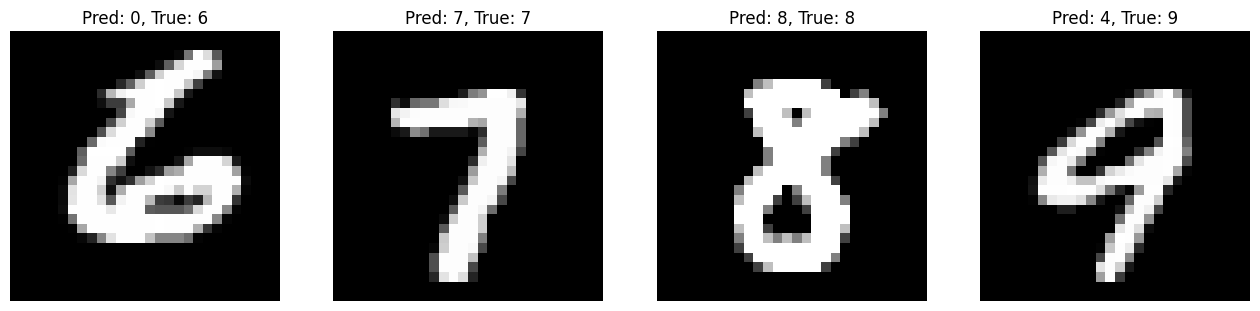

In [29]:
plot(
    [X_test[i] for i in [15, 6, 7, 8]],
    [f"Pred: {all_preds[-1][i]}, True: {y_test[i]}" for i in [15, 6, 7, 8]]
)

Our simple MLP with two FC layers acheived a pretty high accuracy. But that was mainly due to the simplicity of the dataset. Processing bigger datasets, also with a more challenging goal in mind (e.g. object detection, segmentation, etc), in addition to huge computational resources, requires from a model to understand **spatial relationship** in the images.

When we reshape our image pixels into a single dimension two major things happen: (i) input size of our neurons drastically increases (a $224 \times 224$ pixel RGB image is more than 150,000 input dimension for a FC neuron), and (ii) we lose important information about the pixels: their spatial location. It would make sense, if we could somehow also train our model to learn, for example, which pixels are close to each other. Most probably a combination of pixels (_superpixels_) make up a wheel of a car, or an ear of an animal. It would be great to look at pixels not as distinct and unrelated items (which FC layer does), but as connected and spatially related items.

## Cross-Correlation Operation


<div class="admonition info">
  <p class="admonition-title">Info</p>
  <p style="margin: 1em 0;">
    The following source was consulted in preparing this material: Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. <a href="https://d2l.ai/">Dive into Deep Learning</a>. Cambridge University Press.
    <a href="https://d2l.ai/chapter_convolutional-neural-networks/index.html">Chapter 7: Convolutional Neural Networks</a>.
  </p>
</div>

The word "convolution" is actually a misnomer, and "cross-correlation" would be a more precise name for the operation which we will discuss now. As can be seen from the figure below, we have a 2D input tensor (image) and a **kernel** of size $2 \times 2$. We can put such a kernel onto four different locations in the image (top left, which we see in the image, top right, bottom left and bottom right). The output is calculated by a simple [dot product](../../mathematics/02_linear_algebra): all the overlapping values are multiplied to each other and summed up.

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
     Given the image dimensions and the kernel size, how many times can we move kernel over the image?
  </p>
</div>

<figure>
  <img src="../../assets/images/cnn/correlation.svg" alt="Cross-Correlation operation" style="max-width: 100%; height: auto;">
  <figcaption style="margin-top: 0.5em; font-size: 0.9em; opacity: 0.85;">
    Cross-correlation operation ~ Zhang et al., <a href='https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html'>Dive into Deep Learning</a>, <a href="https://d2l.ai/_images/correlation.svg">Fig. 7.2.1</a>.
    <a href="https://creativecommons.org/licenses/by-sa/4.0/">CC BY-SA 4.0</a>.
    
  </figcaption>
</figure>

The code below sets up the input image and kernel described in the figure.

In [30]:
img = torch.arange(9).reshape((1,3,3))
kernel = torch.arange(4).reshape((1,2,2))

img, kernel

(tensor([[[0, 1, 2],
          [3, 4, 5],
          [6, 7, 8]]]),
 tensor([[[0, 1],
          [2, 3]]]))

If the kernel width is the same as image width, we can put kernel only once on each row of the image. If kernel width is $1$ pixel less than the image width dimension, we can put kernel twice on the image row. The same rule applies to height and vertical movement of the kernel over the image. From that, we can determine the number of steps kernel will move over the image.

In [31]:
horizontal_steps = img.shape[1] - kernel.shape[1] + 1 # height
vertical_steps   = img.shape[2] - kernel.shape[2] + 1 # width

We will now use for loops for calculating cross-correlation operation, but note that we do it for simplicity, and using loops isn't an efficient choice. Whenever we can, we should use vectorized operations provided by Pytroch. Finally, pay attention how `squeeze/unsqueeze` functions take care of the channel dimension below.

<div class="admonition warning">
  <p class="admonition-title">Important</p>
  <p style="margin: 1em 0;">
    Vectorization in PyTorch is the practice of replacing explicit loops with optimized tensor operations. It leverages highly efficient C++ and CUDA kernels to speed up computation on both CPUs and GPUs. This is a fundamental performance optimization in deep learning. Therefore, loops in code should be avoided as much as possible.
  </p>
</div>



In [32]:
out = torch.zeros((horizontal_steps, vertical_steps))
for i in range(horizontal_steps):
  for j in range(vertical_steps):
    patch = img.squeeze()[i:kernel.shape[1]+i, j:kernel.shape[2]+j]
    out[i, j] = torch.sum(kernel.squeeze() * patch)
out = out.unsqueeze(0)
out

tensor([[[19., 25.],
         [37., 43.]]])

The good news is that we do not have to implement complicated (and inefficient) cross-correlation operations in higher dimensions. `torch.nn.functional` provides functions for that, which, however accept arguments in 4-dimensions, the first dimension being batch size. Again, pay attention to `squeeze` and `unsqueeze` shapes, which will add and remove the fourth (batch) dimension.

In [33]:
import torch.nn.functional as F

out = F.conv2d(img.unsqueeze(0), kernel.unsqueeze(0)).squeeze(1)
out

tensor([[[19, 25],
         [37, 43]]])

## Kernels

Kernels are capable of extracting relevant features from images. We can choose different kernels, depending on what we try to detect in the image. To see how kernel values influence the output of the cross-correlation operation, let's see the following edge detection example. Edges in the toy image below are the points where pixel values change extremely (from $0$ to $1$ or vice versa).

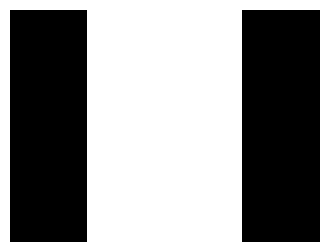

In [34]:
img = torch.zeros((1, 6, 8))
img[:, :, 2:6] = 1.0
plot(img)

In [35]:
img, img.shape

(tensor([[[0., 0., 1., 1., 1., 1., 0., 0.],
          [0., 0., 1., 1., 1., 1., 0., 0.],
          [0., 0., 1., 1., 1., 1., 0., 0.],
          [0., 0., 1., 1., 1., 1., 0., 0.],
          [0., 0., 1., 1., 1., 1., 0., 0.],
          [0., 0., 1., 1., 1., 1., 0., 0.]]]),
 torch.Size([1, 6, 8]))


<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
     What kind of kernel would be appropriate for detecting edges?
  </p>
</div>

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
     Try to understand why the kernel below detects the edges. Hint: manually calculate the cross-correlation step.
  </p>
</div>

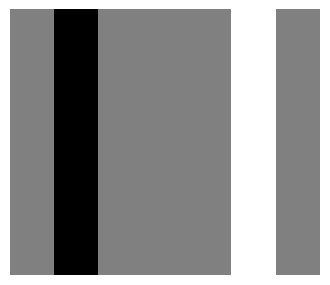

In [36]:
kernel = torch.tensor([[[1.0, -1.0]]])
out = F.conv2d(img.unsqueeze(0), kernel.unsqueeze(0)).squeeze(1)
plot(out)

In [37]:
out, out.shape

(tensor([[[ 0., -1.,  0.,  0.,  0.,  1.,  0.],
          [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
          [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
          [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
          [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
          [ 0., -1.,  0.,  0.,  0.,  1.,  0.]]]),
 torch.Size([1, 6, 7]))

There exists [many ready kernels](<https://en.wikipedia.org/wiki/Kernel_(image_processing)#Details>) to manipulate images for sharpening, blurring, edge detection, etc. But what if we wanted to learn more complicated kernels, how to achieve that? Can we learn correct kernel values, say, for detecting an ear of a dog? It turns out, given image and the edge detected output, we can train a model and learn the kernel.

Instead of MLP with linear (FC) layers, we will use a single convolutional layer provided by PyTorch to learn the kernel. `nn.Conv2d` requires from us to specify the input dimensions, when `nn.LazyConv2d` will determine the dimension dynamically, when we pass the input image to the model. Note that we are [overfitting](../../introduction/02_machine_learning) the model (layer) to a single example.

Our goal is to learn a single kernel of size $1 \times 2$ for a grayscale image. What the convolutional layer does under the hood we will learn soon. How to train a model we had already seen when training MLP on MNIST. Notice how our model manages to quickly learn a perfect kernel.

In [38]:
model = nn.LazyConv2d(out_channels=1, kernel_size=(1, 2)).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

X_img = img.to(device).unsqueeze(0)
y_out = out.to(device).unsqueeze(0)

epochs = 100

for e in range(epochs):
  optimizer.zero_grad()
  preds = model(X_img)
  loss = torch.sum((preds - y_out) ** 2) # mse
  loss.backward()
  optimizer.step()

print(f'Epoch: {e+1}/{epochs}, Loss: {loss:.4f}')
print(f'Learned Kernel: {model.weight.data}')

Epoch: 100/100, Loss: 0.0000
Learned Kernel: tensor([[[[ 1.0000, -1.0000]]]], device='cuda:0')


As our final examples, let's take (i) a simple blur kernel which averages pixels within its frame, and (ii) a [Gaussian](../../mathematics/03_probability) blur kernel which is basically giving more weight to the pixels that are closer to the middle, by considering Gaussian (normal) distribution . We will apply them on a photo of [Eileen Collins](https://en.wikipedia.org/wiki/Eileen_Collins) and see the output. Note that [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) is commonly used for detecting edges

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    Modify the size of the kernel to see how it influences the output.
  </p>
</div>


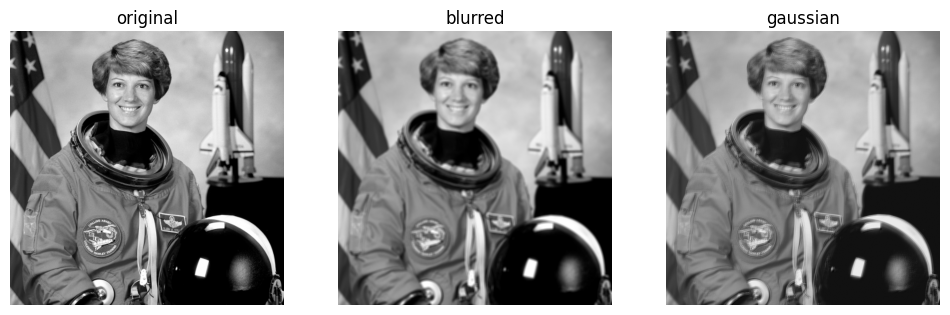

In [41]:
from skimage import data

test_img = data.astronaut()
test_img = torch.tensor(test_img, dtype=torch.float32).permute(2,0,1) # C, H, W
test_img = test_img.mean(0).unsqueeze(0) # RGB to grayscale

H = W = 5 # try out bigger kernel sizes
mean, std = 0.0, 1.0 # mean and standard deviation of Gaussian distribution

blur_kernel = torch.ones((1,H,W)) * 1/H*W # averaging pixels
gaussian_blur_kernel = torch.normal(mean, std, size=(1,H,W)) # pixels closer to middle get more weight

blurred  = F.conv2d(test_img.unsqueeze(0), blur_kernel.unsqueeze(0)).squeeze(1)
gaussian = F.conv2d(test_img.unsqueeze(0), gaussian_blur_kernel.unsqueeze(0)).squeeze(1)

plot([test_img, blurred, gaussian], ['original', 'blurred', 'gaussian'])


<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
    See this <a href='https://setosa.io/ev/image-kernels/'>visualization</a> and this <a href='https://www.youtube.com/watch?v=8rrHTtUzyZA'>demonstration</a> (in the beginning of the video) for gaining further intuition on how different kernels influence an image. The video titled <em><a href='https://www.youtube.com/watch?v=KuXjwB4LzSA&t=538s'>But what is a convolution?</a></em> explains cross-correlation and kernel operations in a nice visual way.
  </p>
</div>

## Padding & Stride

When we find `valid` cross-correlation, we move kernel within the constraints of the image. As a consequence, we pass through boundaries only once, losing some spatial information (pixels on the corners are barely used). **Padding** resolves this issue.

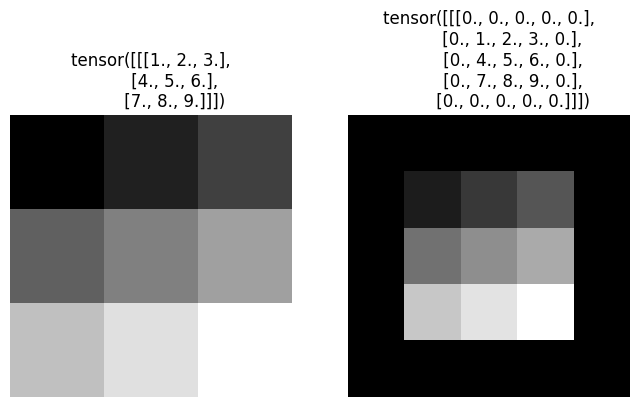

In [42]:
img = torch.arange(1., 10).reshape((1,3,3))
padded_img = F.pad(img, (1,1,1,1)) # left right top bottom
plot([img, padded_img], [f'{img}', f'{padded_img}'])

By default, we step with kernel one row/column at a time (as in the image above). **Stride** determines the step size of our kernel, which is used when we want to reduce the output dimensionality after cross-correlation even further. It may be useful when the kernel size is big, we need faster computation, etc.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    From this point on, we will replace the more accurate word "cross-correlation" with the accepted terminology "convolution". Simply put, convolution operation is equivalent to the 90 degrees rotated cross-correlation operation.
  </p>
</div>


<figure>
  <img src="../../assets/images/cnn/convolution.gif" alt="Cross-Correlation operation" style="max-width: 100%; height: auto;">
  <figcaption style="margin-top: 0.5em; font-size: 0.9em; opacity: 0.85;">
    Kernel convolution with unit padding and stride ~ By <a href="//commons.wikimedia.org/w/index.php?title=User:Plotke&amp;action=edit&amp;redlink=1" class="new" title="User:Plotke (page does not exist)">Michael Plotke</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=24288958">Link</a>
  </figcaption>
</figure>

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
  Manually calculate the strided convolution below.
  </p>
</div>

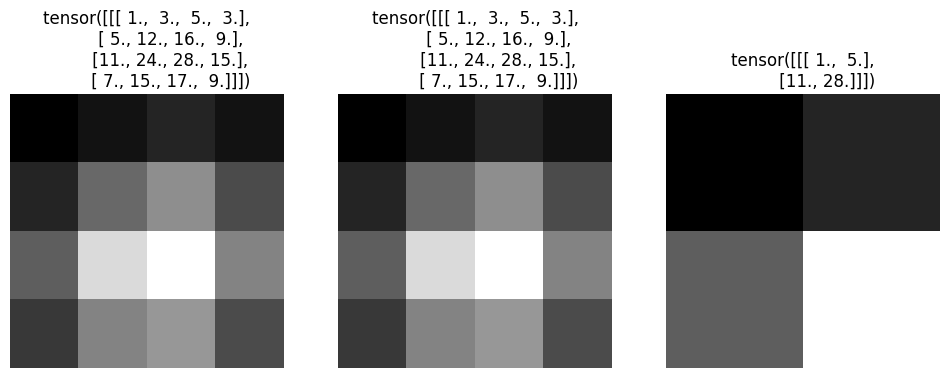

In [43]:
kernel = torch.ones((1,1,2,2))

manual_padding = F.conv2d(padded_img.unsqueeze(0), kernel).squeeze(1)
conv2d_padding = F.conv2d(img.unsqueeze(0), kernel, padding=1).squeeze(1)
conv2d_stride  = F.conv2d(img.unsqueeze(0), kernel, padding=1, stride=2).squeeze(1)

plot([manual_padding, conv2d_padding, conv2d_stride],
     [f'{manual_padding}', f'{conv2d_padding}', f'{conv2d_stride}'])

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    Create 100 random images (colored) and calculate the output dimension after the convolution operation. Calculate and print out how many features will be passed to the next layer after flattening the feature maps for all the cases below:
    <table style="font-size: 0.9em">
    <thead>
            <tr>
            <th>Image Size</th>
            <th>Kernel Size</th>
            <th>Stride</th>
            <th>Padding</th>
            </tr>
        </thead>
        <tbody>
            <tr>
            <td>30×30</td>
            <td>3×3</td>
            <td>1</td>
            <td>0</td>
            </tr>
            <tr>
            <td>224×224</td>
            <td>5×5</td>
            <td>2</td>
            <td>1</td>
            </tr>
            <tr>
            <td>528×528</td>
            <td>7×7</td>
            <td>3</td>
            <td>2</td>
            </tr>
        </tbody>
        </table>
    </p>
</div>
<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    In practice, we need to compute the output size of convolution layers when designing CNN architectures, debugging tensor shape mismatches, and determining how many features will be produced before flattening. For that, we need to realize that the output spatial size of a convolution depends on four parameters: input size, kernel size, padding, and stride and come up with the following formula which is also used by deep learning frameworks internally:
    $$
    \text{out} = \left\lfloor \frac{\text{input} - \text{kernel} + 2\cdot\text{padding}}{\text{stride}} \right\rfloor + 1
    $$
    Intuitively, subtracting kernel size from an input dimension tells how much the kernel can slide inside the input, padding increases the usable space by adding extra pixels around the borders, and stride controls how many pixels the kernel jumps at each step. The floor operation appears because the kernel must fully fit inside the padded image. This formula is applied separately for height and width.
  </p>
</div>


## Multiple Channels

So far we have been working with grayscale images. When we increase the channels $C$, we will simply have $C$ number of kernels. We will apply convolution of each kernel to their corresponding channels and eventually sum them up.

<figure>
  <img src="../../assets/images/cnn/conv-multi.svg" alt="Cross-correlation computation with two input channels" style="max-width: 100%; height: auto;">
  <figcaption style="margin-top: 0.5em; font-size: 0.9em; opacity: 0.85;">
    Cross-correlation computation with two input channels ~ Zhang et al.,
    <a href="https://d2l.ai/chapter_convolutional-neural-networks/channels.html">Dive into Deep Learning</a>,
    <a href='https://d2l.ai/_images/conv-multi-in.svg'>Fig. 7.4.1</a>.
    <a href="https://creativecommons.org/licenses/by-sa/4.0/">CC BY-SA 4.0</a>.
  </figcaption>
</figure>

We will implement the operation descibed in the figure by using ready PyTorch functions.

In [44]:
img = torch.cat((torch.arange(9.), torch.arange(1.,10))).reshape((1,2,3,3))
img

tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]],

         [[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])

In [45]:
kernels = torch.cat((torch.arange(4.), torch.arange(1.,5))).reshape((1,2,2,2))
kernels

tensor([[[[0., 1.],
          [2., 3.]],

         [[1., 2.],
          [3., 4.]]]])

In [46]:
conv1 = F.conv2d(img[:,0:1,:,:], kernels[:,0:1,:,:])
conv2 = F.conv2d(img[:,1:2,:,:], kernels[:,1:2,:,:])

conv1 + conv2

tensor([[[[ 56.,  72.],
          [104., 120.]]]])

In [47]:
# or equivalently
F.conv2d(img, kernels)

tensor([[[[ 56.,  72.],
          [104., 120.]]]])

We may want to not only deal with multiple channels, but also output multiple channels. The simplistic reasoning for it could be that each output channel may hold different feature information. For that, we will apply convolution of each kernel set to the whole image (all dimensions) and eventually concatenate the results along the channel axis.

In [48]:
torch.cat([F.conv2d(img, kernels+i) for i in range(3)], dim=0)

tensor([[[[ 56.,  72.],
          [104., 120.]]],


        [[[ 76., 100.],
          [148., 172.]]],


        [[[ 96., 128.],
          [192., 224.]]]])

## Maximum & Average Pooling

The advantage of convolutional layers is that, unlike FC layers, they take into account spatial information about the pixels (their locations, neighbors, etc). But how can we make sure that our predictions will not be very sensitive to small changes in pixel locations? Because a cat image where the cat is streching is still a cat image, and our model should correctly classify it, even if it hasn't seen a stretching cat during training. As we will see, applying a **pooling** operation will help with **spatial invariance**, as well as _downsample_ the representations of the previous layer.

The figure below describes _maximum pooling_ operation, which resembles a kernel, but instead of convolution, simply takes the maximum pixel value within the given range. Similarly, an _average pooling_ operation, averages all the corresponding pixels and is equivalent to the simple blur kernel which we saw previously.

<figure>
  <img src="../../assets/images/cnn/pooling.svg" alt="Pooling operation" style="max-width: 100%; height: auto;">
  <figcaption style="margin-top: 0.5em; font-size: 0.9em; opacity: 0.85;">
    Pooling operation ~ Zhang et al.,
    <a href="https://d2l.ai/chapter_convolutional-neural-networks/pooling.html">Dive into Deep Learning</a>,
    <a href='https://d2l.ai/_images/pooling.svg'>Fig. 7.5.1</a>.
    <a href="https://creativecommons.org/licenses/by-sa/4.0/">CC BY-SA 4.0</a>.
  </figcaption>
</figure>

Below is the code implementation of the described operations, first implemented manually, then calculated by using ready functions provided by PyTorch.

In [49]:
img_channel = img.unbind(1)[0] # unbinds from the channel dimension and takes the first channel
img_channel

tensor([[[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]]])

In [50]:
operation = ['avg','max'][1] # change to 0 for average poolig

# Compare the code below with the convolution code
kernel_height = kernel_width = 2

horizontal_steps = img_channel.shape[1] - kernel_height + 1
vertical_steps   = img_channel.shape[2] - kernel_width  + 1

out = torch.zeros((horizontal_steps, vertical_steps))
for i in range(horizontal_steps):
  for j in range(vertical_steps):
    patch = img_channel.squeeze(0)[i:i+kernel_height, j:j+kernel_width]
    out[i, j] = patch.mean() if operation == 'avg' else patch.max()

out.unsqueeze(0)

tensor([[[4., 5.],
         [7., 8.]]])

In [51]:
# or equivalently
nn.MaxPool2d(kernel_size=(2,2), stride=1, padding=0)(img_channel)

tensor([[[4., 5.],
         [7., 8.]]])

In [52]:
nn.AvgPool2d(kernel_size=(2,2), stride=1, padding=0)(img_channel)

tensor([[[2., 3.],
         [5., 6.]]])

In multiple dimensions, instead of summing channel outputs of each kernel, we will concatenate them after the pooling operation, which makes sense, as we have to retain channel information. Notice that the output channel is 2D, as we pass both image channels to `nn.MaxPool2d()`.

In [53]:
nn.MaxPool2d(kernel_size=2, stride=1, padding=0)(img)

tensor([[[[4., 5.],
          [7., 8.]],

         [[5., 6.],
          [8., 9.]]]])

## Convolutional Neural Network


We will now implement the well-known [LeNet-5](https://en.wikipedia.org/wiki/LeNet) (1998) architecture. Its _convolutional block_ consists of a convolution layer, sigmoid activation function (convolution is a linear function), and average pooling layer. Kernel size of convolutional layers is $5 \times 5$ (with initial padding of $2$). Two convolutional layers output $6$ and $16$ feature maps respectively. Average pooling kernel size is $2 \times 2$ (with stride $2$).

<div class="admonition warning">
  <p class="admonition-title">Important</p>
  <p style="margin: 1em 0;">
    Sigmoid often causes <a href='../04_regul_optim'>vanishing gradients</a> and average pooling tends to <em>smooth out</em> strong local features. The superiority of max-pooling and rectifier activation were discovered only about a decade later, which soon became a default choice.
</div>

Once we extract the relevant features with convolutional blocks, we will have to make predictions with FC layers. For that, we must flatten the feature maps similar to what we did when using our simple `MLP` class, which was directly accepting the image as its inputs, instead of convolutional feature maps. FC layer sizes proposed in the paper are $120$, $84$, $10$, classifying 10 handwritten digits.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    The origins of CNN go back to the 1980 paper called
    <a href="https://www.rctn.org/bruno/public/papers/Fukushima1980.pdf" target="_blank" rel="noopener noreferrer">
        Neocognitron: A Self-organizing Neural Network Model for a Mechanism of Pattern Recognition Unaffected by Shift in Position
    </a>
    by <em>Kunihiko Fukushima</em>. As computational power increased and the field developed, an influential CNN implementation
    by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner was introduced in the 1998 paper called
    <a href="http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf" target="_blank" rel="noopener noreferrer">
        Gradient-Based Learning Applied to Document Recognition
    </a>.
    The convolutional network architecture proposed for detecting handwritten digits (and more) was named after its first author as
    <em>LeNet</em>.
  </p>
</div>

<figure>
  <img src="../../assets/images/cnn/lenet.svg" alt="Data flow in LeNet" style="max-width: 100%; height: auto;">
  <figcaption style="margin-top: 0.5em; font-size: 0.9em; opacity: 0.85;">
    Data flow in LeNet: the input is a handwritten digit, the output is a probability over 10 possible outcomes ~ Zhang et al.,
    <a href="https://d2l.ai/chapter_convolutional-neural-networks/lenet.html">Dive into Deep Learning</a>,
    <a href='https://d2l.ai/_images/lenet.svg'>Fig. 7.6.1.</a>
    <a href="https://creativecommons.org/licenses/by-sa/4.0/">CC BY-SA 4.0</a>.
  </figcaption>
</figure>

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    Code the model architecture by using the knowledge of the <code>MLP</code> class and the information provided above.
    </p>
</div>

We will now code and train a modern implementation with `LeNet`, similar to `MLP`. We will replace average pooling with maximum pooling layer, sigmoid with ReLU activation, and the original Gaussian decoder with softmax function. We will use `Lazy` versions of the layers in order to not hard-code input dimensions.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
   During training we will use cross-entropy loss, which applies <code>log_softmax</code> internally in a numerically stable way, so we do not include a softmax layer inside the model.
</div>

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.LazyConv2d(out_channels=6, kernel_size=(5,5), padding=2)
    self.conv2 = nn.LazyConv2d(out_channels=16, kernel_size=(5,5))
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.LazyLinear(out_features=84)
    self.fc2 = nn.LazyLinear(out_features=10)
    self.act = nn.ReLU()

  def forward(self, X):
    block1 = self.pool(self.act(self.conv1(X)))
    block2 = self.pool(self.act(self.conv2(block1)))
    flatten = block2.view(block2.shape[0], -1)
    logits = self.fc2(self.act(self.fc1(flatten)))
    return logits

## Sequential Module in PyTorch

Before testing our convolutional network, we will rewrite our original classes in order to demonstrate the power and clarity of `nn.Sequential` module in `PyTorch`. The code below is self-explanatory and is equivalent to `MLP` and `LeNet` classes we had initilaized previously. Notice how simple it is.

In [ ]:
mlp = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(out_features=128),
    nn.ReLU(),
    nn.LazyLinear(out_features=10),
)

lenet = nn.Sequential(
    nn.LazyConv2d(out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.LazyConv2d(out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.LazyLinear(out_features=84),
    nn.ReLU(),
    nn.LazyLinear(out_features=10),
)

## Training & Inference

We will abstract away our model initalization, train and inference codes before testing our models, similar to when we [built a classifier](../../02_neural_network) from scratch in the style of [scikit-learn](https://scikit-learn.org/) library to train on the `make_moons` dataset. Both the training and inference logic we had seen in this notebook earlier. The only difference is that the code is now modularized to ease experimentations.

In [ ]:
class Classifier:
  def __init__(self, model, lr=0.01):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model = model.to(self.device)
    self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
    self.loss_fn = nn.CrossEntropyLoss()

  def fit(self, train_loader, num_epochs=10):
    self.model.train()
    for epoch in range(num_epochs):
      loss = 0.0
      for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(self.device), y_train.to(self.device)
        self.optimizer.zero_grad()
        logits = self.model(X_train)
        batch_loss = self.loss_fn(logits, y_train)
        batch_loss.backward()
        loss += batch_loss.item()
        self.optimizer.step()
      print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss/len(train_loader):.4f}")

  def inference(self, test_loader):
    self.model.eval()
    correct = 0
    all_preds = []
    with torch.no_grad():
      for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(self.device), y_test.to(self.device)
        logits = self.model(X_test)
        _, top_preds = torch.max(logits, dim=1)
        correct += (top_preds == y_test).sum().item()
        all_preds.append(top_preds)
    accuracy = 100 * correct / len(test_loader.dataset)
    print(f"Accuracy on test data: {accuracy:.2f}%")

It is important to note that convolutions are expensive matrix operations, when GPUs will come in aid. Also, do not rush to compare `MLP` with `LeNet`, as our `MNIST` dataset is very simple. Indeed, almost three decades have passed since the first implementation of _LeNet-5_!

In [57]:
clf_mlp = Classifier(mlp)
clf_mlp.fit(train_loader)
clf_mlp.inference(test_loader)

Epoch: 1/10, Loss: 2.2945
Epoch: 2/10, Loss: 2.2347
Epoch: 3/10, Loss: 2.0805
Epoch: 4/10, Loss: 1.9504
Epoch: 5/10, Loss: 1.8545
Epoch: 6/10, Loss: 1.7976
Epoch: 7/10, Loss: 1.7676
Epoch: 8/10, Loss: 1.7202
Epoch: 9/10, Loss: 1.6920
Epoch: 10/10, Loss: 1.6772
Accuracy on test data: 83.01%


In [58]:
clf_lenet = Classifier(lenet)
clf_lenet.fit(train_loader)
clf_lenet.inference(test_loader)

Epoch: 1/10, Loss: 2.3023
Epoch: 2/10, Loss: 2.3013
Epoch: 3/10, Loss: 2.2997
Epoch: 4/10, Loss: 2.2959
Epoch: 5/10, Loss: 2.2707
Epoch: 6/10, Loss: 1.9000
Epoch: 7/10, Loss: 1.6895
Epoch: 8/10, Loss: 1.6566
Epoch: 9/10, Loss: 1.6208
Epoch: 10/10, Loss: 1.5827
Accuracy on test data: 89.61%


In this notebook, we introduced the core building blocks of convolutional neural networks and applied them to handwritten digit classification on the MNIST dataset. We studied the cross-correlation operation, the role of kernels, and how padding and stride control the spatial output size of convolution layers. We then extended convolution to multiple input and output channels, introduced max pooling and average pooling for downsampling, and assembled a modern version of the LeNet architecture. We also introduced PyTorch and demonstrated its capacity when implementing training and inference of deep learning models. In the next notebook, we will discuss many optimization and regularization techniques of artificial neural networks.
